## Package install and setup

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade multiscale-spatial-image matplotlib tifffile zarr ome-types dask_image

In [25]:
from multiscale_spatial_image import to_multiscale, Methods
from spatial_image import is_spatial_image, to_spatial_image
import tifffile
import os
from urllib.request import urlretrieve
import zarr
import ome_types
import dask.array as da
import datatree
from numcodecs import Blosc

## Download example image

Lightsheet volume [from the human cortex](https://dandiarchive.org/dandiset/000026/draft/files?location=rawdata%2Fsub-I46%2Fses-SPIM%2F).

Mazzamuto, Giacomo; Costantini, Irene; Gavryusev, Vladislav; Castelli, Filippo Maria; Pesce, Luca; Scardigli, Marina; Pavone, Francesco Saverio; Roffilli, Matteo; Silvestri, Ludovico; Brady, Niamh; Ramazzotti, Josephine; Hof, Patrick R.; Boas, David A.; Fischl, Bruce; Morgan, Leah; Yang, Jiarui; Chang, Shuaibin; Laffey, Jessie; Magnain, Caroline; Varadarajan, Divya; Wang, Hui; Frost, Robert; Kouwe, Andre van der; Player, Allison Stevens; Atzeni, Alessia; Gonzalez, Juan Eugenio Iglesias; Balbastre, Yael; Vera, Matthew; Cordero, Devani; Nestor, Kimberly; Ammon, William; Nolan, Jackson; Mora, Jocelyn; Pallares, Erendira Garcia; Augustinack, Jean; Diamond, Bram; Fogarty, Morgan; Boyd, Emma; Varghese, Merina; Dalca, Adrian V.; Edlow, Brian; Frosche, Matthew; Wicinski, Bridget; Chen, I-Chun Anderson (2022) Human brain cell census for BA 44/45 (Version draft) [Data set]. DANDI archive. https://dandiarchive.org/dandiset/000026/draft

In [6]:
image_name = 'sub-I46_ses-SPIM_sample-BrocaAreaS01_stain-GAD67_chunk-00_SPIM'
filename = f'{image_name}.ome.tif'
if not os.path.exists(filename):
    url = f'https://api.dandiarchive.org/api/assets/fcb6c425-ee14-4247-b2e4-d2550273f1f3/download'
    urlretrieve(url, filename)

## Inspect metadata, data

In [7]:
tiff = tifffile.TiffFile(filename)

[OME-TIFF](https://docs.openmicroscopy.org/ome-model/6.2.2/)'s contain useful, standardized metadata and have broad community adoption.

In [8]:
tiff.is_ome

True

In [9]:
tiff.ome_metadata

'<ome:OME xmlns:ome="http://www.openmicroscopy.org/Schemas/OME/2016-06" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd">\n    <ome:Image ID="Image:0" Name="sub-I46_sample-BrocaAreaS01_stain-GAD67_SPIM">\n        <ome:AcquisitionDate>2019-10-01T00:00:00</ome:AcquisitionDate>\n        <ome:Pixels BigEndian="false" DimensionOrder="XYZCT" ID="Pixels:0" Interleaved="false" SizeC="1" SizeT="1" SizeX="3882" SizeY="342" SizeZ="242" Type="uint16" PhysicalSizeX="3.3" PhysicalSizeXUnit="µm" PhysicalSizeY="3.3" PhysicalSizeYUnit="µm" PhysicalSizeZ="3.3" PhysicalSizeZUnit="µm">\n            <ome:Channel ID="Channel:00" SamplesPerPixel="1" Name="GAD67" ExcitationWavelength="638" EmissionWavelength="690" ExcitationWavelengthUnit="nm" EmissionWavelengthUnit="nm" Fluor="Alexa Fluor 647">\n                <ome:LightPath />\n            </ome:Channel>\n        <ome:TiffDa

In [10]:
ome = ome_types.from_xml(tiff.ome_metadata)
print(ome)

binary_only=None creator=None datasets=[] experimenter_groups=[] experimenters=[] experiments=[] folders=[] images=[Image(
   id='Image:0',
   name='sub-I46_sample-BrocaAreaS01_stain-GAD67_SPIM',
   pixels=Pixels(
      id='Pixels:0',
      dimension_order='XYZCT',
      size_c=1,
      size_t=1,
      size_x=3882,
      size_y=342,
      size_z=242,
      type='uint16',
      big_endian=False,
      channels=[<1 Channels>],
      interleaved=False,
      physical_size_x=3.3,
      physical_size_y=3.3,
      physical_size_z=3.3,
      tiff_data_blocks=[<1 Tiff_Data_Blocks>],
   ),
   acquisition_date=datetime.fromisoformat('2019-10-01T00:00:00'),
)] instruments=[] plates=[] projects=[] rights=None rois=[] screens=[] structured_annotations=[] uuid=None


In [11]:
dims = [d for d in tiff.series[0].axes.lower().replace('i', 'z').replace('s', 'c')]
dims

['z', 'y', 'x']

In [12]:
scale = { d:getattr(ome.images[0].pixels, f"physical_size_{d}") for d in dims}
scale

{'z': 3.3, 'y': 3.3, 'x': 3.3}

In [13]:
axis_units = { d:str(getattr(ome.images[0].pixels, f"physical_size_{d}_quantity").units) for d in dims}
axis_units

{'z': 'micrometer', 'y': 'micrometer', 'x': 'micrometer'}

In [14]:
data_store = tiff.series[0].aszarr()
zarr_data = zarr.open(data_store, 'r')
data = da.array(zarr_data)
data

dask.array<array, shape=(242, 342, 3882), dtype=uint16, chunksize=(50, 342, 3882), chunktype=numpy.ndarray>

In [15]:
name = ome.images[0].name
name

'sub-I46_sample-BrocaAreaS01_stain-GAD67_SPIM'

In [16]:
image = to_spatial_image(data, dims=dims, name=name, scale=scale, axis_units=axis_units)
image

<xarray.SpatialImage 'sub-I46_sample-BrocaAreaS01_stain-GAD67_SPIM' (z: 242,
                                                                     y: 342,
                                                                     x: 3882)>
dask.array<array, shape=(242, 342, 3882), dtype=uint16, chunksize=(50, 342, 3882), chunktype=numpy.ndarray>
Coordinates:
  * z        (z) float64 0.0 3.3 6.6 9.9 13.2 ... 782.1 785.4 788.7 792.0 795.3
  * y        (y) float64 0.0 3.3 6.6 9.9 ... 1.119e+03 1.122e+03 1.125e+03
  * x        (x) float64 0.0 3.3 6.6 9.9 ... 1.28e+04 1.28e+04 1.281e+04

## Generate isotropically chunked, multiscale spatial image

In [17]:
help(to_multiscale)

Help on function to_multiscale in module multiscale_spatial_image:

to_multiscale(image: spatial_image.SpatialImage, scale_factors: Sequence[Union[Dict[str, int], int]], method: Optional[multiscale_spatial_image.Methods] = None, chunks: Union[int, Tuple[int, ...], Tuple[Tuple[int, ...], ...], Mapping[Any, Union[NoneType, int, Tuple[int, ...]]], NoneType] = None) -> multiscale_spatial_image.MultiscaleSpatialImage
    Generate a multiscale representation of a spatial image.
    
    Parameters
    ----------
    
    image : SpatialImage
        The spatial image from which we generate a multi-scale representation.
    
    scale_factors : int per scale or dict of spatial dimension int's per scale
        Integer scale factors to apply uniformly across all spatial dimension or
        along individual spatial dimensions.
        Examples: [2, 2] or [{'x': 2, 'y': 4 }, {'x': 5, 'y': 10}]
    
    method : multiscale_spatial_image.Methods, optional
        Method to reduce the input image.

In [19]:
# Isotropic 128x128x128 chunks
chunks = 128

multiscale = to_multiscale(image,
                           [{'x':2,'y':1,'z':1},{'x':4,'y':2,'z':2},{'x':8,'y':4,'z':4}],
                           method=Methods.DASK_IMAGE_GAUSSIAN,
                           chunks=chunks)
print(multiscale)

DataTree('None', parent=None)
├── DataTree('scale0')
│       Dimensions:                                       (z: 242, y: 342, x: 3882)
│       Coordinates:
│         * z                                             (z) float64 0.0 3.3 ... 795.3
│         * y                                             (y) float64 0.0 ... 1.125e+03
│         * x                                             (x) float64 0.0 ... 1.281e+04
│       Data variables:
│           sub-I46_sample-BrocaAreaS01_stain-GAD67_SPIM  (z, y, x) uint16 dask.array<chunksize=(128, 128, 128), meta=np.ndarray>
├── DataTree('scale1')
│       Dimensions:                                       (z: 242, y: 342, x: 1941)
│       Coordinates:
│         * z                                             (z) float64 0.0 3.3 ... 795.3
│         * y                                             (y) float64 0.0 ... 1.125e+03
│         * x                                             (x) float64 1.65 ... 1.281e+04
│       Data variables:
│      

In [20]:
# Now the data has isotropic chunking
multiscale['scale0'].ds[name].data

dask.array<rechunk-merge, shape=(242, 342, 3882), dtype=uint16, chunksize=(128, 128, 128), chunktype=numpy.ndarray>

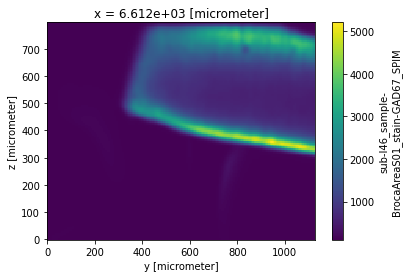

In [21]:
multiscale['scale2'].ds[name].isel(x=250).plot.imshow()

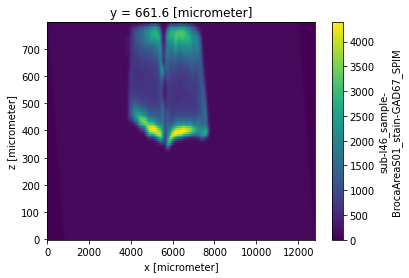

In [22]:
multiscale['scale2'].ds[name].isel(y=100).plot.imshow()

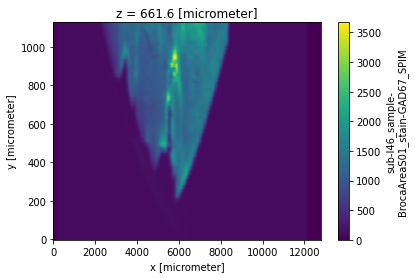

In [23]:
multiscale['scale2'].ds[name].isel(z=100).plot.imshow()

## Serialize as OME-NGFF Zarr 

Generate an Open Microscopy Environment-Next Generation File Format [OME-NGFF](https://ngff.openmicroscopy.org/latest/) dataset.

Here we also uses the [*bioformats2raw* transitional layout](https://github.com/ome/ngff/pull/112) to preserve the OME-XML metadata.

In [26]:
store = zarr.storage.DirectoryStore(f'{image_name}.zarr', dimension_separator='/')
group = zarr.group(store, overwrite=True)
group.attrs['bioformats2raw.layout'] = 3
store['OME/METADATA.ome.xml'] = tiff.ome_metadata.encode('utf-8')

# Compression options
compressor = Blosc(cname='zstd', clevel=5, shuffle=Blosc.SHUFFLE)

# For OME-NGFF, large datasets, use dimension_separator='/'
store = zarr.storage.DirectoryStore(f'{image_name}.zarr/0', dimension_separator='/')
multiscale.to_zarr(store, encoding={ name: { 'compressor': compressor }})

### Deserialize

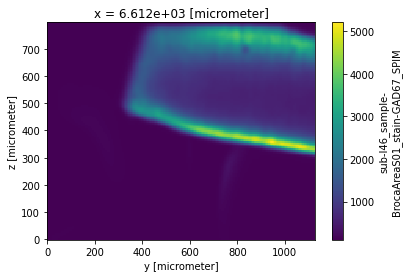

In [27]:
store = zarr.storage.DirectoryStore(f'{image_name}.zarr/0', dimension_separator='/')

new_multiscale = datatree.open_datatree(store, engine='zarr')
new_multiscale['scale2'].ds[name].isel(x=250).plot.imshow()